In [1]:
import torch, torchaudio, torchvision.transforms as transforms, matplotlib.pyplot as plt, torch.nn as nn, torch.optim as optim, numpy as np
from torchvision.models import vgg16, VGG16_Weights
from torch.utils.data import DataLoader, TensorDataset
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import  StratifiedKFold
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix, auc, classification_report, roc_auc_score
from torch.autograd import grad

cuda0 = torch.device("cuda:0")
cuda1 = torch.device("cuda:1")
device = cuda1
print(torch.cuda.get_device_name(device) if torch.cuda.is_available() else "No GPU available")

data = np.load("../../hvcm/RFQ.npy", allow_pickle=True)
label = np.load("../../hvcm/RFQ_labels.npy", allow_pickle=True)
label = label[:, 1]  # Assuming the second column is the label
label = (label == "Fault").astype(int)  # Convert to binary labels
print(data.shape, label.shape)

normal_indices = np.where(label == 0)

NVIDIA A30
(872, 4500, 14) (872,)


# Time GAN

In [2]:
class Embedder(nn.Module):
    """Embedding network between original feature space and latent space."""
    def __init__(self, input_dim, hidden_dim, num_layers):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # Architecture
        self.rnn = nn.GRU(
            input_size=input_dim, 
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True
        )
    
    def forward(self, X):
        """Forward pass for embedding.
        
        Args:
            X: input time series features, shape [batch_size, seq_len, input_dim]
            
        Returns:
            H: latent representation, shape [batch_size, seq_len, hidden_dim]
        """
        H, _ = self.rnn(X)
        return H

class Recovery(nn.Module):
    """Recovery network from latent space to original space."""
    def __init__(self, hidden_dim, output_dim, num_layers):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        
        # Architecture
        self.rnn = nn.GRU(
            input_size=hidden_dim, 
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True
        )
        self.output_layer = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, H):
        """Forward pass for recovery.
        
        Args:
            H: latent representation, shape [batch_size, seq_len, hidden_dim]
            
        Returns:
            X_tilde: recovered data, shape [batch_size, seq_len, output_dim]
        """
        H_tilde, _ = self.rnn(H)
        X_tilde = self.output_layer(H_tilde)
        return X_tilde

class Generator(nn.Module):
    """Generator network for generating synthetic data."""
    def __init__(self, z_dim, hidden_dim, num_layers):
        super().__init__()
        self.z_dim = z_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # Architecture
        self.rnn = nn.GRU(
            input_size=z_dim, 
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True
        )
    
    def forward(self, Z):
        """Forward pass for generator.
        
        Args:
            Z: random noise, shape [batch_size, seq_len, z_dim]
            
        Returns:
            H_hat: generated latent data, shape [batch_size, seq_len, hidden_dim]
        """
        H_hat, _ = self.rnn(Z)
        return H_hat

class Supervisor(nn.Module):
    """Supervisor network for predicting next sequence step."""
    def __init__(self, hidden_dim, num_layers):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # Architecture
        self.rnn = nn.GRU(
            input_size=hidden_dim, 
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True
        )
    
    def forward(self, H):
        """Forward pass for supervisor.
        
        Args:
            H: latent representation, shape [batch_size, seq_len, hidden_dim]
            
        Returns:
            H_hat_supervise: predicted next step, shape [batch_size, seq_len, hidden_dim]
        """
        H_hat_supervise, _ = self.rnn(H)
        return H_hat_supervise

class Discriminator(nn.Module):
    """Discriminator network between real and synthetic data."""
    def __init__(self, hidden_dim, num_layers):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # Architecture
        self.rnn = nn.GRU(
            input_size=hidden_dim, 
            hidden_size=hidden_dim,
            num_layers=num_layers-1,
            batch_first=True
        )
        self.linear = nn.Linear(hidden_dim, 1)
    
    def forward(self, H):
        """Forward pass for discriminator.
        
        Args:
            H: latent representation, shape [batch_size, seq_len, hidden_dim]
            
        Returns:
            Y: discrimination result, shape [batch_size, seq_len, 1]
        """
        features, _ = self.rnn(H)
        Y = self.linear(features)
        return Y

In [3]:
# Add this chunking function after your imports
def chunk_sequences(data, chunk_size=100, overlap=10):
    """
    Split long sequences into smaller chunks
    
    Args:
        data: shape [n_samples, seq_len, features] = (690, 4500, 14)
        chunk_size: size of each chunk
        overlap: overlap between chunks
    
    Returns:
        chunked_data: shape [n_chunks, chunk_size, features]
    """
    n_samples, seq_len, n_features = data.shape
    chunks = []
    
    for sample in data:
        # Create chunks with overlap
        for start in range(0, seq_len - chunk_size + 1, chunk_size - overlap):
            end = start + chunk_size
            if end <= seq_len:
                chunks.append(sample[start:end])
    
    return np.array(chunks)

# Update your loss functions to be more stable
def embedding_loss(X, X_tilde):
    """
    Robust reconstruction loss using relative error
    """
    # Use relative L1 loss to handle large values
    return torch.mean(torch.abs(X - X_tilde) / (torch.abs(X) + 1e-6))


def supervised_loss(H, H_hat_supervise):
    """
    Supervised loss for the supervisor network - with safety check
    """
    if H.size(1) > 1:
        return torch.mean(torch.abs(H[:, 1:, :] - H_hat_supervise[:, :-1, :]))
    return torch.tensor(0.0, device=H.device)

def discriminator_loss(Y_real, Y_fake):
    """
    Discriminator loss using BCE with logits for stability
    """
    criterion = nn.BCEWithLogitsLoss()
    real_loss = criterion(Y_real, torch.ones_like(Y_real))
    fake_loss = criterion(Y_fake, torch.zeros_like(Y_fake))
    return real_loss + fake_loss

def generator_loss(Y_fake, H, H_hat_supervise, X, X_hat, lambda_sup=1.0, lambda_recon=0.01):
    """
    Generator loss with MUCH lower reconstruction weight for raw data
    """
    criterion = nn.BCEWithLogitsLoss()
    
    # Adversarial loss
    loss_adv = criterion(Y_fake, torch.ones_like(Y_fake))
    
    # Supervised loss
    loss_sup = supervised_loss(H, H_hat_supervise)
    
    # Relative reconstruction loss (VERY low weight for raw data)
    loss_recon = torch.mean(torch.abs(X - X_hat) / (torch.abs(X) + 1e-6))
    
    # CRITICAL: Much lower reconstruction weight for raw data
    total_loss = loss_adv + lambda_sup * loss_sup + lambda_recon * loss_recon
    return total_loss

In [4]:
# Updated training function with chunking support
# Updated training function WITHOUT normalization
def train_timegan(data, seq_len, batch_size, model_params, train_params):
    """
    Train TimeGAN model with chunked sequences (no normalization)
    """
    # Chunk the sequences directly without normalization
    chunk_size = seq_len  # Use the provided seq_len as chunk size
    print(f"Chunking sequences into size {chunk_size}...")
    chunked_data = chunk_sequences(data, chunk_size=chunk_size, overlap=10)
    print(f"Created {len(chunked_data)} chunks from {len(data)} original sequences")
    
    # Model parameters
    input_dim = model_params['input_dim']
    hidden_dim = model_params['hidden_dim']
    num_layers = model_params['num_layers']
    z_dim = model_params['z_dim']
    
    # Training parameters
    epochs = train_params['epochs']
    learning_rate = train_params['learning_rate']
    
    # Create dataset and loader
    data_tensor = torch.tensor(chunked_data, dtype=torch.float32)
    dataset = TensorDataset(data_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # Initialize models
    embedder = Embedder(input_dim, hidden_dim, num_layers).to(device)
    recovery = Recovery(hidden_dim, input_dim, num_layers).to(device)
    generator = Generator(z_dim, hidden_dim, num_layers).to(device)
    supervisor = Supervisor(hidden_dim, num_layers).to(device)
    discriminator = Discriminator(hidden_dim, num_layers).to(device)
    
    # Initialize optimizers with different learning rates
    e_optimizer = optim.Adam(list(embedder.parameters()) + list(recovery.parameters()), lr=learning_rate)
    g_optimizer = optim.Adam(list(generator.parameters()) + list(supervisor.parameters()), lr=learning_rate)
    d_optimizer = optim.Adam(discriminator.parameters(), lr=learning_rate * 0.1)  # Slower discriminator
    
    print('Start training TimeGAN...')
    
    for epoch in range(epochs):
        step_e_loss = 0
        step_g_loss = 0
        step_d_loss = 0
        
        for batch_idx, (X_mb,) in enumerate(dataloader):
            X_mb = X_mb.to(device)
            batch_size_actual = X_mb.shape[0]
            
            # Phase 1: Embedding network training (every iteration)
            embedder.train()
            recovery.train()
            
            H = embedder(X_mb)
            X_tilde = recovery(H)
            
            e_loss = embedding_loss(X_mb, X_tilde)
            
            e_optimizer.zero_grad()
            e_loss.backward()
            torch.nn.utils.clip_grad_norm_(list(embedder.parameters()) + list(recovery.parameters()), 1.0)
            e_optimizer.step()
            
            step_e_loss += e_loss.item()
            
            # Phase 2: Train generator and discriminator (every few iterations)
            if batch_idx % 2 == 0:  # Train G and D every 2 iterations
                # Generator training
                generator.train()
                supervisor.train()
                
                Z_mb = torch.randn(batch_size_actual, seq_len, z_dim).to(device)
                H_hat = generator(Z_mb)
                H_hat_supervise = supervisor(H_hat)
                X_hat = recovery(H_hat)
                
                # Get embeddings from real data
                with torch.no_grad():
                    H_real = embedder(X_mb)
                
                # Discriminator outputs
                Y_fake = discriminator(H_hat)
                
                # Generator loss
                g_loss = generator_loss(Y_fake, H_real, H_hat_supervise, X_mb, X_hat)
                
                g_optimizer.zero_grad()
                g_loss.backward()
                torch.nn.utils.clip_grad_norm_(list(generator.parameters()) + list(supervisor.parameters()), 1.0)
                g_optimizer.step()
                
                step_g_loss += g_loss.item()
                
                # Discriminator training
                discriminator.train()
                
                # Generate new samples for discriminator
                Z_mb_d = torch.randn(batch_size_actual, seq_len, z_dim).to(device)
                with torch.no_grad():
                    H_hat_d = generator(Z_mb_d)
                    H_real_d = embedder(X_mb)
                
                Y_fake_d = discriminator(H_hat_d)
                Y_real_d = discriminator(H_real_d)
                
                d_loss = discriminator_loss(Y_real_d, Y_fake_d)
                
                d_optimizer.zero_grad()
                d_loss.backward()
                torch.nn.utils.clip_grad_norm_(discriminator.parameters(), 1.0)
                d_optimizer.step()
                
                step_d_loss += d_loss.item()
        
        # Print progress with reasonable scaling
        num_batches = len(dataloader)
        avg_e_loss = step_e_loss / num_batches
        avg_g_loss = step_g_loss / (num_batches // 2) if num_batches > 2 else step_g_loss / max(1, num_batches)
        avg_d_loss = step_d_loss / (num_batches // 2) if num_batches > 2 else step_d_loss / max(1, num_batches)
        
        print(f'Epoch {epoch+1}/{epochs}:')
        print(f'  Embedding loss: {avg_e_loss:.4f}')
        print(f'  Generator loss: {avg_g_loss:.4f}')
        print(f'  Discriminator loss: {avg_d_loss:.4f}')
    
    return {
        'embedder': embedder,
        'recovery': recovery,
        'generator': generator,
        'supervisor': supervisor,
        'discriminator': discriminator,
        'chunk_size': chunk_size,
        'original_seq_len': data.shape[1]
    }

# Updated generation function for chunks
# Updated generation function for chunks (NO DENORMALIZATION)
def generate_timegan_samples(model, n_samples, seq_len, z_dim):
    """
    Generate synthetic samples (raw data - no denormalization needed)
    """
    generator = model['generator']
    supervisor = model['supervisor']
    recovery = model['recovery']
    
    # Generate random noise
    Z = torch.randn(n_samples, seq_len, z_dim).to(device)
    
    # Generate synthetic data
    with torch.no_grad():
        generator.eval()
        supervisor.eval()
        recovery.eval()
        
        H_hat = generator(Z)
        H_hat = supervisor(H_hat)
        X_hat = recovery(H_hat)
    
    # Return raw generated data (no denormalization needed)
    return X_hat.cpu().numpy()

def reconstruct_full_sequences(chunks, original_length=4500, chunk_size=100, overlap=10):
    """
    Reconstruct full sequences from generated chunks
    """
    step_size = chunk_size - overlap
    chunks_needed = (original_length - overlap) // step_size
    
    n_full_sequences = len(chunks) // chunks_needed
    full_sequences = []
    
    for i in range(n_full_sequences):
        start_idx = i * chunks_needed
        end_idx = start_idx + chunks_needed
        sequence_chunks = chunks[start_idx:end_idx]
        
        # Reconstruct by overlapping chunks
        reconstructed = np.zeros((original_length, sequence_chunks.shape[2]))
        pos = 0
        
        for j, chunk in enumerate(sequence_chunks):
            if j == 0:
                reconstructed[pos:pos + chunk_size] = chunk
                pos += step_size
            else:
                # Average overlapping regions
                overlap_start = pos
                overlap_end = pos + overlap
                if overlap_end <= original_length:
                    reconstructed[overlap_start:overlap_end] = (
                        reconstructed[overlap_start:overlap_end] + chunk[:overlap]
                    ) / 2
                    reconstructed[pos + overlap:pos + chunk_size] = chunk[overlap:]
                    pos += step_size
        
        full_sequences.append(reconstructed)
    
    return np.array(full_sequences)

## Train and Combine

In [5]:
# Update your model instantiation code - NO NORMALIZATION
# Model parameters - updated for chunked approach
chunk_size = 100  # Much more manageable than 4500
input_dim = data.shape[2]  # 14 features
hidden_dim = 32  # Reduced for stability
num_layers = 2   # Fewer layers
z_dim = input_dim
seq_len = chunk_size  # Use chunk size as sequence length
batch_size = 64  # Larger batch size for chunks

model_params = {
    'input_dim': input_dim,
    'hidden_dim': hidden_dim,
    'num_layers': num_layers,
    'z_dim': z_dim
}

train_params = {
    'epochs': 50,  # Fewer epochs initially
    'learning_rate': 0.0001  # Higher learning rate
}

# Convert data to tensor and create a subset for training (NO NORMALIZATION)
normal_data = data[normal_indices]
print(f"Original data shape: {normal_data.shape}")
print(f"Training on {len(normal_data)} normal samples")

# Train the TimeGAN model on RAW data
trained_model = train_timegan(normal_data, seq_len, batch_size, model_params, train_params)


Original data shape: (690, 4500, 14)
Training on 690 normal samples
Chunking sequences into size 100...
Created 33810 chunks from 690 original sequences
Start training TimeGAN...
Epoch 1/50:
  Embedding loss: 0.9998
  Generator loss: 0.7774
  Discriminator loss: 1.5009
Epoch 2/50:
  Embedding loss: 0.9925
  Generator loss: 0.4900
  Discriminator loss: 1.7775
Epoch 3/50:
  Embedding loss: 0.9910
  Generator loss: 0.5168
  Discriminator loss: 1.7195
Epoch 4/50:
  Embedding loss: 0.9909
  Generator loss: 0.5753
  Discriminator loss: 1.6204
Epoch 5/50:
  Embedding loss: 0.9891
  Generator loss: 0.6150
  Discriminator loss: 1.5658
Epoch 6/50:
  Embedding loss: 0.9884
  Generator loss: 0.6876
  Discriminator loss: 1.4663
Epoch 7/50:
  Embedding loss: 0.9866
  Generator loss: 0.7703
  Discriminator loss: 1.3766
Epoch 8/50:
  Embedding loss: 0.9854
  Generator loss: 0.8009
  Discriminator loss: 1.3510
Epoch 9/50:
  Embedding loss: 0.9838
  Generator loss: 0.7690
  Discriminator loss: 1.3886
Ep

In [6]:
# Updated generation parameters for 690 full sequences
n_full_sequences_desired = 690  # Match your normal data count
chunks_per_sequence = 45  # (4500-10)//(100-10) = 4490//90 = 49.89 ≈ 50 chunks actually

# More precise calculation
step_size = chunk_size - 10  # 90
chunks_per_sequence = (4500 - 10) // step_size + 1  # More accurate: 50 chunks per sequence
n_synthetic_chunks = n_full_sequences_desired * chunks_per_sequence

print(f"Generating {n_full_sequences_desired} full sequences:")
print(f"Chunks per sequence: {chunks_per_sequence}")
print(f"Total chunks needed: {n_synthetic_chunks}")

# Generate synthetic chunks
synthetic_chunks = generate_timegan_samples(trained_model, n_synthetic_chunks, seq_len, z_dim)
print(f"Generated {synthetic_chunks.shape} synthetic chunks")

# Reconstruct ALL full sequences (not just 100)
synthetic_full = reconstruct_full_sequences(
    synthetic_chunks,
    original_length=4500,
    chunk_size=chunk_size
)
print(f"Reconstructed {synthetic_full.shape} full synthetic sequences")

# Combine with original data
combine_normal_data = np.concatenate((synthetic_full, normal_data), axis=0)
combine_normal_labels = np.concatenate((np.zeros(len(synthetic_full)), label[normal_indices]), axis=0)

print(f"Combined data shape: {combine_normal_data.shape}")
print(f"Combined labels shape: {combine_normal_labels.shape}")
print(f"Synthetic normal samples: {len(synthetic_full)}")

Generating 690 full sequences:
Chunks per sequence: 50
Total chunks needed: 34500
Generated (34500, 100, 14) synthetic chunks
Reconstructed (704, 4500, 14) full synthetic sequences
Combined data shape: (1394, 4500, 14)
Combined labels shape: (1394,)
Synthetic normal samples: 704


# Processing: Mel Spec > Resizing > Feature Extraction

In [7]:
def resize_spectrogram(spectrogram, global_min=None, global_max=None):
    """
    Improved spectrogram processing with consistent normalization
    """
    # Use global min/max for consistent normalization across all spectrograms
    if global_min is not None and global_max is not None:
        spectrogram = (spectrogram - global_min) / (global_max - global_min + 1e-8)
    else:
        spectrogram = (spectrogram - spectrogram.min()) / (spectrogram.max() - spectrogram.min() + 1e-8)
    
    # Clip to [0,1] and convert to uint8
    spectrogram = np.clip(spectrogram, 0, 1)
    spectrogram = np.uint8(spectrogram.cpu().numpy() * 255)
    spectrogram = np.stack([spectrogram] * 3, axis=-1)
    
    image = Image.fromarray(spectrogram)
    image = transforms.Resize((224, 224))(image)
    return transforms.ToTensor()(image)

def process_dataset_improved(data, sample_rate=1000):  # More reasonable sample rate
    """
    Improved dataset processing with better mel-spectrogram parameters
    """
    num_samples, seq_len, num_channels = data.shape
    features = np.zeros((num_samples, num_channels, 4096))
    
    # Better mel-spectrogram parameters for sensor data
    mel_transform = torchaudio.transforms.MelSpectrogram(
        sample_rate=sample_rate,
        n_mels=128,
        n_fft=512,          # Reasonable FFT size
        hop_length=256,     # 50% overlap
        win_length=512,
        window_fn=torch.hann_window
    ).to(device)
    
    # Load VGG16 model
    model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1).to(device)
    model.classifier = model.classifier[:-3]
    model.eval()
    
    # Compute global min/max for consistent normalization
    print("Computing global spectrogram statistics...")
    all_mels = []
    for i in range(min(100, num_samples)):  # Sample subset for statistics
        for j in range(num_channels):
            ts = torch.tensor(data[i, :, j], dtype=torch.float32).to(device)
            mel = mel_transform(ts)
            all_mels.append(mel.cpu().numpy())
    
    all_mels = np.concatenate([mel.flatten() for mel in all_mels])
    global_min, global_max = np.percentile(all_mels, [1, 99])  # Use percentiles to avoid outliers
    
    print(f"Processing {num_samples} samples...")
    for i in range(num_samples):
        if i % 100 == 0:
            print(f"Processed {i}/{num_samples} samples")
            
        for j in range(num_channels):
            ts = torch.tensor(data[i, :, j], dtype=torch.float32).to(device)
            mel = mel_transform(ts)
            
            # Use consistent normalization
            img = resize_spectrogram(mel, global_min, global_max)
            
            with torch.no_grad():
                feat = model(img.unsqueeze(0).to(device))
            features[i, j, :] = feat.squeeze().cpu().numpy()
    
    return features

# Alternative: Multi-channel processing
def process_dataset_multichannel(data, sample_rate=1000):
    """
    Process multiple channels together to capture cross-channel relationships
    """
    num_samples, seq_len, num_channels = data.shape
    features = np.zeros((num_samples, 4096))  # Single feature vector per sample
    
    mel_transform = torchaudio.transforms.MelSpectrogram(
        sample_rate=sample_rate,
        n_mels=128,
        n_fft=512,
        hop_length=256,
        win_length=512
    ).to(device)
    
    model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1).to(device)
    model.classifier = model.classifier[:-3]
    model.eval()
    
    print(f"Processing {num_samples} samples with multi-channel approach...")
    for i in range(num_samples):
        if i % 100 == 0:
            print(f"Processed {i}/{num_samples} samples")
        
        # Combine multiple channels into RGB image
        channel_spectrograms = []
        for j in range(min(3, num_channels)):  # Use first 3 channels as RGB
            ts = torch.tensor(data[i, :, j], dtype=torch.float32).to(device)
            mel = mel_transform(ts)
            
            # Normalize each channel spectrogram
            mel_norm = (mel - mel.min()) / (mel.max() - mel.min() + 1e-8)
            mel_resized = torch.nn.functional.interpolate(
                mel_norm.unsqueeze(0).unsqueeze(0), 
                size=(224, 224), 
                mode='bilinear'
            ).squeeze()
            channel_spectrograms.append(mel_resized.cpu().numpy())
        
        # Stack as RGB image
        if len(channel_spectrograms) == 1:
            rgb_img = np.stack([channel_spectrograms[0]] * 3, axis=0)
        elif len(channel_spectrograms) == 2:
            rgb_img = np.stack([channel_spectrograms[0], channel_spectrograms[1], channel_spectrograms[0]], axis=0)
        else:
            rgb_img = np.stack(channel_spectrograms[:3], axis=0)
        
        img_tensor = torch.tensor(rgb_img, dtype=torch.float32).unsqueeze(0).to(device)
        
        with torch.no_grad():
            feat = model(img_tensor)
        features[i, :] = feat.squeeze().cpu().numpy()
    
    return features

# Mel Scale comparison

# AE Class

In [8]:
# Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, input_size=4096):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 64), 
            nn.Tanh(),
            nn.Linear(64, 32), 
            nn.Tanh(),
            nn.Linear(32, 16), 
            nn.Tanh(),
            nn.Linear(16, 8), 
            nn.Tanh(),
            nn.Linear(8, 4), 
            nn.Tanh()
        )
        self.decoder = nn.Sequential(
            nn.Linear(4, 8),
            nn.Tanh(),
            nn.Linear(8, 16), 
            nn.Tanh(),
            nn.Linear(16, 32), 
            nn.Tanh(),
            nn.Linear(32, 64), 
            nn.Tanh(),
            nn.Linear(64, input_size), 
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))


# Train autoencoder
def train_autoencoder(features, epochs=20, batch_size=128):
    x = torch.tensor(features.reshape(-1, 4096), dtype=torch.float32).to(device)
    loader = DataLoader(TensorDataset(x), batch_size=batch_size, shuffle=True)
    model = Autoencoder().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)  # Add weight decay
    criterion = nn.MSELoss()  # Try MSE instead of L1

    for epoch in range(epochs):
        total_loss = 0
        for batch in loader:
            inputs = batch[0]
            # Add noise for denoising autoencoder
            noisy_inputs = inputs + 0.1 * torch.randn_like(inputs)
            outputs = model(noisy_inputs)
            loss = criterion(outputs, inputs)  # Reconstruct clean from noisy
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(loader):.6f}")
    return model

# Compute reconstruction errors
def compute_reconstruction_loss(model, data, add_noise=True):
    """
    Compute reconstruction loss per sample (not per segment)
    data: shape (n_samples, n_channels, 4096)
    """
    model.eval()
    n_samples, n_channels, n_features = data.shape
    sample_errors = []
    
    # Flatten to (n_samples*n_channels, 4096) for batch processing
    x = torch.tensor(data.reshape(-1, n_features), dtype=torch.float32).to(next(model.parameters()).device)
    loader = DataLoader(TensorDataset(x), batch_size=64)
    
    all_errors = []
    criterion = torch.nn.MSELoss(reduction='none')
    
    with torch.no_grad():
        for batch in loader:
            inputs = batch[0]
            
            if add_noise:
                noisy_inputs = inputs + 0.1 * torch.randn_like(inputs)
                outputs = model(noisy_inputs)
            else:
                outputs = model(inputs)
            
            # Per-segment reconstruction error
            segment_errors = criterion(outputs, inputs).mean(dim=1)
            all_errors.extend(segment_errors.cpu().numpy())
    
    # Reshape back to (n_samples, n_channels) and aggregate per sample
    all_errors = np.array(all_errors).reshape(n_samples, n_channels)
    sample_errors = all_errors.mean(axis=1)  # Average across channels per sample
    
    return sample_errors

# 2. Find best threshold based on F1 score
def find_best_threshold(errors, labels):
    best_f1 = 0
    best_threshold = 0
    for threshold in np.linspace(min(errors), max(errors), 100):
        preds = (errors > threshold).astype(int)
        f1 = f1_score(labels, preds)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    return best_threshold, best_f1

def evaluate_on_test_with_threshold_search(model, X_test, y_test):
    """
    X_test: shape (n_samples, 1, 4096) - already has channel dimension added
    y_test: shape (n_samples,)
    """
    # X_test already has shape (n_samples, 1, 4096) from your code
    # So we can directly compute reconstruction errors
    test_errors = compute_reconstruction_loss(model, X_test)
    
    best_threshold, best_f1 = find_best_threshold(test_errors, y_test)

    # Predict using best threshold
    test_preds = (test_errors > best_threshold).astype(int)

    # Evaluate
    print(f"Best Threshold = {best_threshold:.6f}, Best F1 Score = {best_f1:.4f}")
    print("Evaluation on Test Set:")
    print("Accuracy =", accuracy_score(y_test, test_preds))
    print("Precision =", precision_score(y_test, test_preds))
    print("Recall =", recall_score(y_test, test_preds))
    print("F1 Score =", f1_score(y_test, test_preds))
    print("Confusion Matrix:\n", confusion_matrix(y_test, test_preds))


# Preprocessing

In [9]:
combine_data = np.concatenate((combine_normal_data, data[label == 1]), axis=0)  # Combine real and generated data
combine_label = np.concatenate((np.zeros(len(combine_normal_labels)), label[label == 1]), axis=0)  # Labels: 0 for real, 0 for generated

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scaled_normal_data = StandardScaler().fit_transform(combine_normal_data.reshape(-1, combine_normal_data.shape[-1])).reshape(combine_normal_data.shape)
scaled_original_data = StandardScaler().fit_transform(data.reshape(-1, data.shape[-1])).reshape(data.shape)
features_original = process_dataset_multichannel(scaled_original_data)
print("Features shape:", features_original.shape)
features_normal = process_dataset_multichannel(scaled_normal_data)
print("Features shape:", features_normal.shape)

Processing 872 samples with multi-channel approach...
Processed 0/872 samples
Processed 100/872 samples
Processed 200/872 samples
Processed 300/872 samples
Processed 400/872 samples
Processed 500/872 samples
Processed 600/872 samples
Processed 700/872 samples
Processed 800/872 samples
Features shape: (872, 4096)
Processing 1394 samples with multi-channel approach...
Processed 0/1394 samples
Processed 100/1394 samples
Processed 200/1394 samples
Processed 300/1394 samples
Processed 400/1394 samples
Processed 500/1394 samples
Processed 600/1394 samples
Processed 700/1394 samples
Processed 800/1394 samples
Processed 900/1394 samples
Processed 1000/1394 samples
Processed 1100/1394 samples
Processed 1200/1394 samples
Processed 1300/1394 samples
Features shape: (1394, 4096)


# Cross Validation without Scalers

Fold 1
Epoch 1/15, Loss: 1.130982
Epoch 2/15, Loss: 0.783338
Epoch 3/15, Loss: 0.562813
Epoch 4/15, Loss: 0.532748
Epoch 5/15, Loss: 0.528465
Epoch 6/15, Loss: 0.527234
Epoch 7/15, Loss: 0.526459
Epoch 8/15, Loss: 0.525900
Epoch 9/15, Loss: 0.525390
Epoch 10/15, Loss: 0.525027
Epoch 11/15, Loss: 0.524682
Epoch 12/15, Loss: 0.524480
Epoch 13/15, Loss: 0.524259
Epoch 14/15, Loss: 0.524079
Epoch 15/15, Loss: 0.523973
Best threshold: 0.5088684510703039, Best F1 Score: 0.6274509803921569


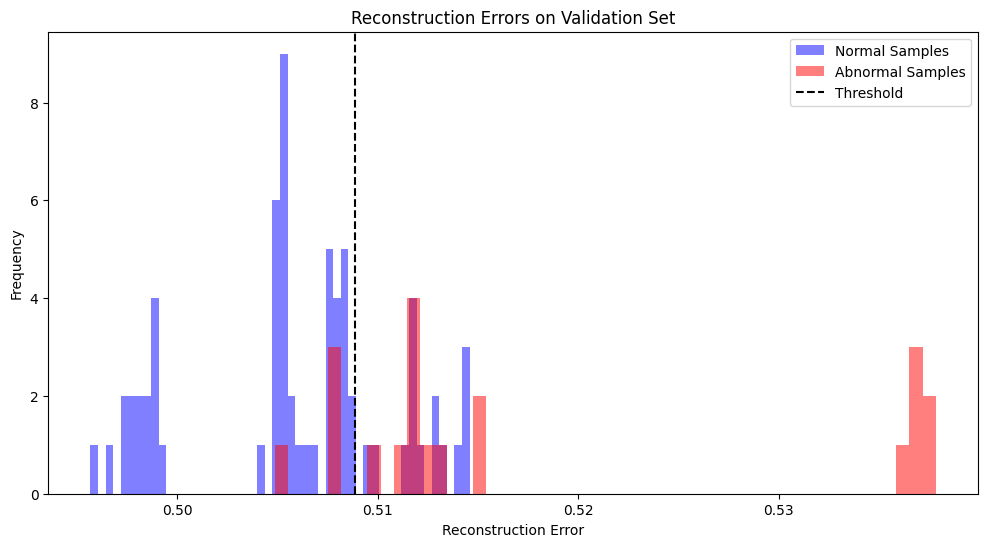

Best Threshold = 0.514408, Best F1 Score = 0.5600
Evaluation on Test Set:
Accuracy = 0.875
Precision = 0.875
Recall = 0.4117647058823529
F1 Score = 0.56
Confusion Matrix:
 [[70  1]
 [10  7]]
Fold 2
Epoch 1/15, Loss: 1.133494
Epoch 2/15, Loss: 0.792339
Epoch 3/15, Loss: 0.563138
Epoch 4/15, Loss: 0.532340
Epoch 5/15, Loss: 0.528302
Epoch 6/15, Loss: 0.527138
Epoch 7/15, Loss: 0.526399
Epoch 8/15, Loss: 0.525888
Epoch 9/15, Loss: 0.525401
Epoch 10/15, Loss: 0.525002
Epoch 11/15, Loss: 0.524721
Epoch 12/15, Loss: 0.524455
Epoch 13/15, Loss: 0.524260
Epoch 14/15, Loss: 0.524054
Epoch 15/15, Loss: 0.523907
Best threshold: 0.5143498928859981, Best F1 Score: 0.7058823529411764


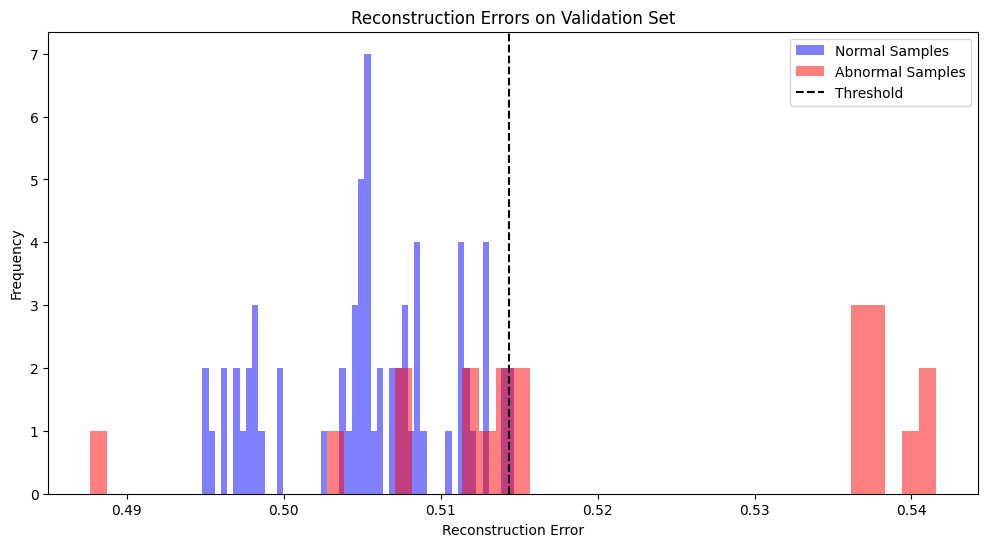

Best Threshold = 0.512146, Best F1 Score = 0.7027
Evaluation on Test Set:
Accuracy = 0.875
Precision = 0.65
Recall = 0.7647058823529411
F1 Score = 0.7027027027027027
Confusion Matrix:
 [[64  7]
 [ 4 13]]
Fold 3
Epoch 1/15, Loss: 1.128897
Epoch 2/15, Loss: 0.766352
Epoch 3/15, Loss: 0.558452
Epoch 4/15, Loss: 0.532363
Epoch 5/15, Loss: 0.528516
Epoch 6/15, Loss: 0.527353
Epoch 7/15, Loss: 0.526460
Epoch 8/15, Loss: 0.525912
Epoch 9/15, Loss: 0.525424
Epoch 10/15, Loss: 0.525049
Epoch 11/15, Loss: 0.524742
Epoch 12/15, Loss: 0.524459
Epoch 13/15, Loss: 0.524275
Epoch 14/15, Loss: 0.524066
Epoch 15/15, Loss: 0.523944
Best threshold: 0.5136775850045561, Best F1 Score: 0.6486486486486486


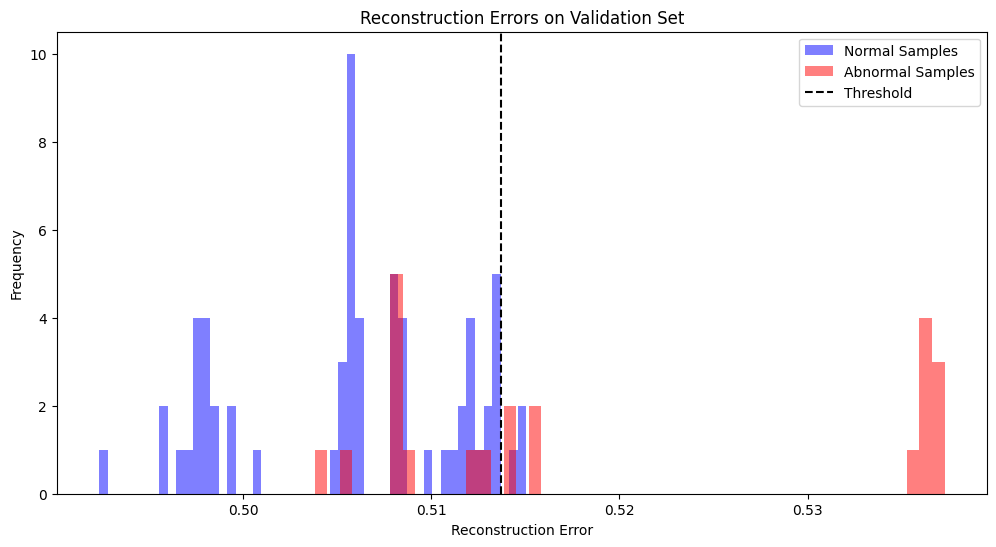

Best Threshold = 0.510285, Best F1 Score = 0.5581
Evaluation on Test Set:
Accuracy = 0.7816091954022989
Precision = 0.41379310344827586
Recall = 0.8571428571428571
F1 Score = 0.5581395348837208
Confusion Matrix:
 [[56 17]
 [ 2 12]]
Fold 4
Epoch 1/15, Loss: 1.148241
Epoch 2/15, Loss: 0.825783
Epoch 3/15, Loss: 0.564885
Epoch 4/15, Loss: 0.530863
Epoch 5/15, Loss: 0.527356
Epoch 6/15, Loss: 0.526576
Epoch 7/15, Loss: 0.526114
Epoch 8/15, Loss: 0.525644
Epoch 9/15, Loss: 0.525230
Epoch 10/15, Loss: 0.524845
Epoch 11/15, Loss: 0.524599
Epoch 12/15, Loss: 0.524361
Epoch 13/15, Loss: 0.524129
Epoch 14/15, Loss: 0.524010
Epoch 15/15, Loss: 0.523859
Best threshold: 0.5114042361577352, Best F1 Score: 0.65


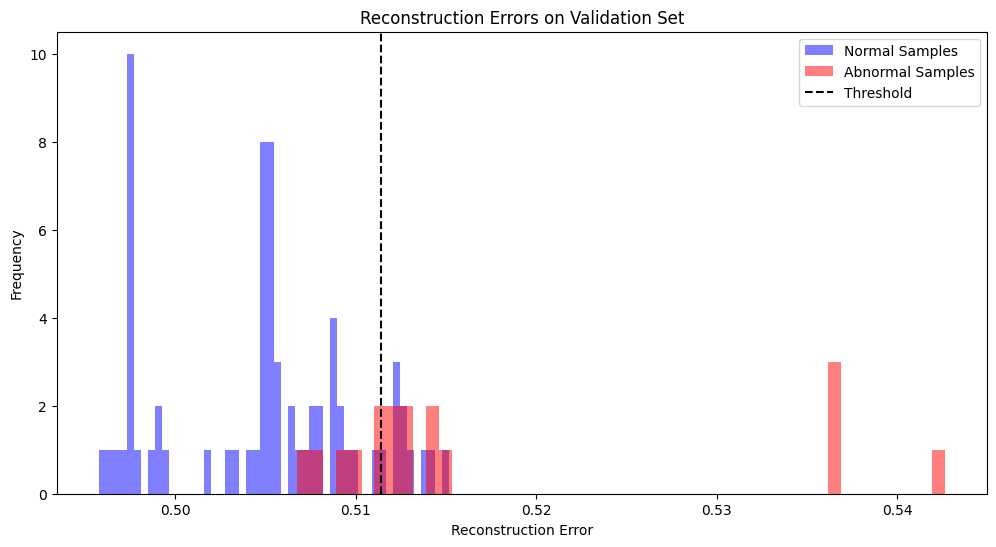

Best Threshold = 0.510020, Best F1 Score = 0.6818
Evaluation on Test Set:
Accuracy = 0.8390804597701149
Precision = 0.6
Recall = 0.7894736842105263
F1 Score = 0.6818181818181819
Confusion Matrix:
 [[58 10]
 [ 4 15]]
Fold 5
Epoch 1/15, Loss: 1.124851
Epoch 2/15, Loss: 0.773498
Epoch 3/15, Loss: 0.562449
Epoch 4/15, Loss: 0.533061
Epoch 5/15, Loss: 0.528659
Epoch 6/15, Loss: 0.527304
Epoch 7/15, Loss: 0.526563
Epoch 8/15, Loss: 0.525925
Epoch 9/15, Loss: 0.525437
Epoch 10/15, Loss: 0.525068
Epoch 11/15, Loss: 0.524762
Epoch 12/15, Loss: 0.524478
Epoch 13/15, Loss: 0.524268
Epoch 14/15, Loss: 0.524066
Epoch 15/15, Loss: 0.523961
Best threshold: 0.5147997453959301, Best F1 Score: 0.7407407407407407


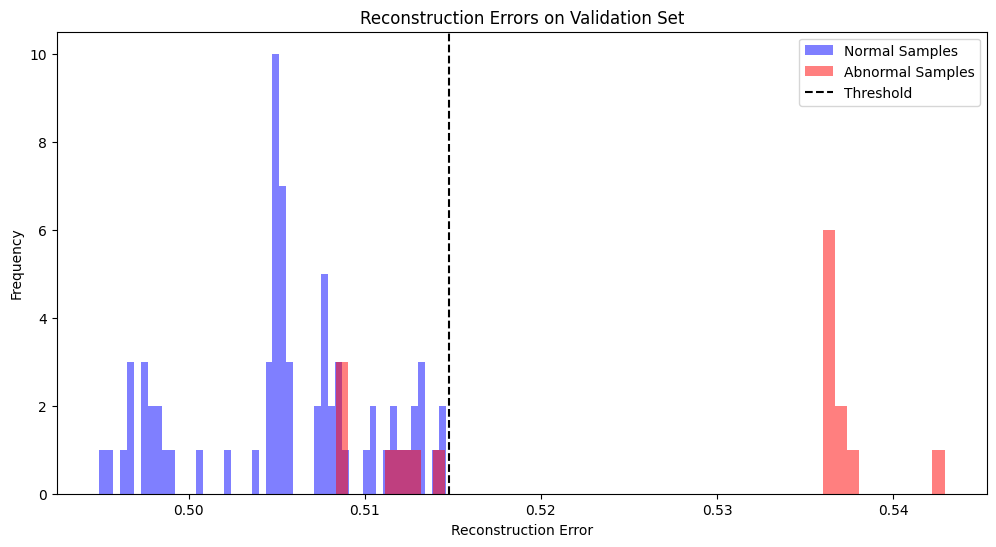

Best Threshold = 0.511504, Best F1 Score = 0.6538
Evaluation on Test Set:
Accuracy = 0.7931034482758621
Precision = 0.5151515151515151
Recall = 0.8947368421052632
F1 Score = 0.6538461538461537
Confusion Matrix:
 [[52 16]
 [ 2 17]]


In [11]:
acc = []
prec = []
rec = []
f1 = []
for fold, (train_idx, val_idx) in enumerate(skf.split(features_original, label)):
    
    print(f"Fold {fold + 1}")
    
   # Get full fold data
    fold_data, fold_labels = features_original[train_idx], label[train_idx]
    val_data, val_labels = features_original[val_idx], label[val_idx]
   
    # Split into training and validation folds
    X_train, X_temp, y_train, y_temp = train_test_split(fold_data, fold_labels, test_size=0.2, shuffle=True, random_state=np.random.randint(0, 1000))
    X_val, X_test, y_val, y_test = train_test_split(val_data, val_labels, test_size=0.5, shuffle=True, random_state=np.random.randint(0, 1000))


    # Train autoencoder on the training fold
    model = train_autoencoder(features_normal, epochs=15, batch_size=64)

    # Add channel dimension to X_val
    X_val = X_val[:, np.newaxis, :]

    # Evaluate on validation fold
    val_normal = X_val[y_val == 0]
    val_abnormal = X_val[y_val == 1]
    val_errors_normal = compute_reconstruction_loss(model, val_normal)
    val_errors_abnormal = compute_reconstruction_loss(model, val_abnormal)
    val_errors = np.concatenate([val_errors_normal, val_errors_abnormal])
    y_val_combined = np.concatenate([np.zeros(len(val_errors_normal)), np.ones(len(val_errors_abnormal))])
    
    threshold, best_f1 = find_best_threshold(val_errors, y_val_combined)
    print(f"Best threshold: {threshold}, Best F1 Score: {best_f1}")

    # Plot histogram of reconstruction errors on both normal and abnormal samples
    plt.figure(figsize=(12, 6))
    plt.hist(val_errors_normal, bins=50, alpha=0.5, label='Normal Samples', color='blue')
    plt.hist(val_errors_abnormal, bins=50, alpha=0.5, label='Abnormal Samples', color='red')
    plt.axvline(threshold, color='black', linestyle='--', label='Threshold')
    plt.title('Reconstruction Errors on Validation Set')
    plt.xlabel('Reconstruction Error')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()
    
    X_test = X_test[:, np.newaxis, :]  # Add channel dimension

    val_errors_test = compute_reconstruction_loss(model, X_test)
    
    # Evaluate on test set
    evaluate_on_test_with_threshold_search(model, X_test, y_test)
    acc.append(accuracy_score(y_test, (val_errors_test > threshold).astype(int)))
    prec.append(precision_score(y_test, (val_errors_test > threshold).astype(int)))
    rec.append(recall_score(y_test, (val_errors_test > threshold).astype(int)))
    f1.append(f1_score(y_test, (val_errors_test > threshold).astype(int)))


In [12]:
print(np.mean(acc), np.mean(prec), np.mean(rec), np.mean(f1))

0.810344827586207 0.6224508240297715 0.5147722246793455 0.5211964483390233


# Observation:




Average scores:

Accuracy = 0.810344827586207

Precision = 0.6224508240297715

Recall = 0.5147722246793455

F1 Score = 0.5211964483390233



Best:

Accuracy = 0.875

Precision = 0.65

Recall = 0.7647058823529411

F1 Score = 0.7027027027027027

Confusion Matrix:

 [[64  7]

 [ 4 13]]